# Importing libraries

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

torch.manual_seed(42)
np.random.seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Our implementation of Compact Transformer Model

In [2]:
# convering image into embeddings
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int=3, patch_size: int=16, embedding_dim: int=192):
        super().__init__()
        # patches are extracted using convolution, 
        self.patches = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size, # non overlapping
                                 padding=0)
        # extracted patches are then flattened into embeddings
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
        
    def forward(self, x):
        x = self.patches(x)
        x = self.flatten(x)
        
        return x.permute(0, 2, 1)
        
        
# MultiHeadAttention Module
class MSA(nn.Module):
    def __init__(self, embedding_dim: int=192, num_heads: int=3, dropout: float=0):
        super().__init__()
        # layer normalization layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # multiheadattention layer
        self.msa_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   dropout=dropout,
                                                   batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        # query, key, value are formed from the same x
        x, _ = self.msa_attention(query=x,
                                    key=x,
                                    value=x,
                                    need_weights=False)
        return x
    
# MLP layer   
class MLP(nn.Module):
    def __init__(self, 
                 embedding_dim: int=192,
                 mlp_size: int=768,
                 dropout: float=0.1):
        super().__init__()
        # layer normalization
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # two linear layers separated by GeLU activation
        self.mlp = nn.Sequential(
                nn.Linear(in_features=embedding_dim,
                        out_features=mlp_size), # from input_dim to mlp_size
                nn.GELU(),
                nn.Dropout(p=dropout),
                nn.Linear(in_features=mlp_size, # from mlp_size to input_dim
                        out_features=embedding_dim),
                nn.Dropout(p=dropout))
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        
        return x
        
# Transformer encoder block
class EncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=192,
                 num_heads: int=3,
                 mlp_size: int=768,
                 mlp_dropout: float=0.1,
                 msa_dropout: float=0.0):
        super().__init__()
        # each block (layer) consists of MSA and MLP
        self.msa = MSA(embedding_dim=embedding_dim,
                       num_heads=num_heads,
                       dropout=msa_dropout)
        
        self.mlp = MLP(embedding_dim=embedding_dim,
                       mlp_size=mlp_size,
                       dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa(x) + x # skip connection #1
        x = self.mlp(x) + x # skip connection #2
        
        return x
    
# ViT class
class ViT(nn.Module):
    def __init__(self,
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 layers: int=12,
                 embedding_dim: int=192,
                 mlp_size: int=768,
                 num_heads: int=3,
                 msa_dropout: float=0.0,
                 mlp_dropout: float=0.1,
                 emb_dropout: float=0.1,
                 num_classes: int=1000):
        super().__init__()
        # calculating number of patches
        self.num_patches = (img_size*img_size) // patch_size**2
        # creating additional class embedding (token)
        self.class_embedding = nn.Parameter(data=torch.rand(1, 1, embedding_dim), requires_grad=True)
        # creating learnable positional embeddings
        self.pos_embedding = nn.Parameter(data=torch.rand(1, self.num_patches+1, embedding_dim), requires_grad=True)
        
        self.emb_dropout = nn.Dropout(p=emb_dropout)
        # image -> embeddings
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        # transformer layers
        self.encoder = nn.Sequential(*[
            EncoderBlock(embedding_dim=embedding_dim,
                         num_heads=num_heads,
                         mlp_size=mlp_size,
                         mlp_dropout=mlp_dropout,
                         msa_dropout=msa_dropout)
            for _ in range(layers)
        ])
        # classification head 
        self.head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        # class token
        cls_token = self.class_embedding.expand(batch_size, -1, -1) 
        
        x = self.patch_embedding(x) # embeddings
        x = torch.cat((cls_token, x), dim=1) # embeddings + class token
        x = self.pos_embedding + x # making positional embeddings
        x = self.emb_dropout(x)
        x = self.encoder(x) # transformer layers
        x = self.head(x[:, 0]) # classification is done based on class embedding (token)
        
        return x
        
# ViT_Ti16 configuration                    # compared to original ViT-B it has smaller D size and MLP size
class ViT_Ti_16(ViT):                       # as well as reduced number of heads 
    def __init__(self,                      # having less than 6 mln params. while ViT-B has 86 mln
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 layers: int=12,
                 embedding_dim: int=192,
                 mlp_size: int=768,
                 num_heads: int=3,
                 msa_dropout: float=0.0,
                 mlp_dropout: float=0.1,
                 emb_dropout: float=0.1,
                 num_classes: int=10):
        super().__init__(patch_size=patch_size,
                         layers=layers,
                         num_classes=num_classes)
 

#ViT_Ti32 configuration   
class ViT_Ti_32(ViT):
    def __init__(self,
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=32,
                 layers: int=12,
                 embedding_dim: int=192,
                 mlp_size: int=768,
                 num_heads: int=3,
                 msa_dropout: float=0.0,
                 mlp_dropout: float=0.1,
                 emb_dropout: float=0.1,
                 num_classes: int=10):
        super().__init__(patch_size=patch_size,
                         layers=layers,
                         num_classes=num_classes)
        
   

# ViT_Lite16 configuration   
class ViT_Lite_16(ViT):
    def __init__(self,
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 layers: int=7,
                 embedding_dim: int=256,
                 mlp_size: int=512,
                 num_heads: int=4,
                 msa_dropout: float=0.0,
                 mlp_dropout: float=0.1,
                 emb_dropout: float=0.1,
                 num_classes: int=10):
        super().__init__(patch_size=patch_size,
                         layers=layers,
                         num_classes=num_classes)
     

# ViT_Lite32 configuration   
class ViT_Lite_32(ViT):
    def __init__(self,
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=32,
                 layers: int=7,
                 embedding_dim: int=256,
                 mlp_size: int=512,
                 num_heads: int=4,
                 msa_dropout: float=0.0,
                 mlp_dropout: float=0.1,
                 emb_dropout: float=0.1,
                 num_classes: int=10):
        super().__init__(patch_size=patch_size,
                         layers=layers,
                         num_classes=num_classes)

# Setting up config Parameters

In [3]:
config = {
    'ROOT_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/train',
    'TEST_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/test',
    'MODELS_DIR': '/kaggle/working/',
    'IMG_SIZE': 224,
    'BATCH_SIZE': 64,
    'EPOCHS': 100,
    'PATIENCE': 7,
    'LR_INIT': 1e-4,
    'WEIGHT_DECAY': 5e-3,
    'NUM_CLASSES': 10,
    'NUM_WORKERS': 4,
    'NUM_CHANNELS': 3,
    'DEVICE': torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
}

# Utility Functions

In [4]:
# train transformations
train_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

# val/test/inference transformations
val_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])


def get_images_labels():
    images = []
    labels = []

    for label in list(glob(os.path.join(config['ROOT_DIR'], '*'))):
        imgs_paths = list(glob(os.path.join(config['ROOT_DIR'], label, '*.jpg')))
        labels.extend([int(label[-1]) for i in range(len(imgs_paths))])
        images.extend([image for image in imgs_paths])
    
    return images, labels


class CNNCustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # getting the path to one image
        img_path = self.images[index]

        image = Image.open(img_path).convert('RGB')
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
def get_dataloaders():
    train_transformations = train_transforms
    val_transformations = val_transforms

    all_images, all_labels = get_images_labels()
    train_images, val_images, train_labels, val_labels = train_test_split(all_images,
                                                                          all_labels,
                                                                          test_size=0.2,
                                                                          random_state=42)
    
    train_dataset = CNNCustomDataset(train_images, train_labels, transform=train_transformations)
    val_dataset = CNNCustomDataset(val_images, val_labels, transform=val_transformations)

    train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=config['NUM_WORKERS'])
    val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

    return train_loader, val_loader

In [6]:
def adjust_learning_rate(optimizer, epoch, warmup=False, warmup_ep=0, enable_cos=True):
    lr = config['LR_INIT']
    if warmup and epoch < warmup_ep:
        lr = lr / (warmup_ep - epoch)
    elif enable_cos:
        lr *= 0.5 * (1. + math.cos(math.pi * (epoch - warmup_ep) / (config['EPOCHS'] - warmup_ep)))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [7]:
def get_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return accuracy, precision, recall, f1

In [8]:
def save_graphs(train, test, type='None'):
    plt.figure(figsize=(10,5))
    plt.title(f"Training and Test {type}")
    plt.plot(test,label="valid")
    plt.plot(train,label="train")
    plt.xlabel("Epoch")
    plt.ylabel(f"{type}")
    plt.legend()
    plt.savefig(f'{type}.png')

# Training Functions

In [9]:
def train(train_loader, model, loss_fn, optimizer, epoch, device):
    model.train()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(train_loader, desc='Training'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch} | Train Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [10]:
def evaluate(val_loader, model, loss_fn, device):
    model.eval()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(val_loader, desc='Validating'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            logits = model(imgs)
            loss = loss_fn(logits, labels)

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(val_loader)

    print(f'\tValidation Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [11]:
def run_training(train_loader, val_loader, model, model_name, loss_fn, optimizer, config):
    TRAIN_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }
    VAL_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }

    # for early stopping
    # we will save the best model based on the validation loss
    best_loss = np.inf  # set to infinity so that the first validation loss is always lower
    patience_counter = 0

    for epoch in range(config['EPOCHS']):
        adjust_learning_rate(optimizer=optimizer, epoch=epoch)
        loss, accuracy, precision, recall, f1 = train(train_loader, model, loss_fn, optimizer, epoch + 1, config['DEVICE'])
        TRAIN_HISTORY['Loss'].append(loss)
        TRAIN_HISTORY['Accuracy'].append(accuracy)
        TRAIN_HISTORY['Precision'].append(precision)
        TRAIN_HISTORY['Recall'].append(recall)
        TRAIN_HISTORY['F1'].append(f1)

        loss, accuracy, precision, recall, f1 = evaluate(val_loader, model, loss_fn, config['DEVICE'])
        VAL_HISTORY['Loss'].append(loss)
        VAL_HISTORY['Accuracy'].append(accuracy)
        VAL_HISTORY['Precision'].append(precision)
        VAL_HISTORY['Recall'].append(recall)
        VAL_HISTORY['F1'].append(f1)

        # since our evaluation metric is logloss, we want to minimize it and early stopping will be based on it
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
            print(f'Saving best model at epoch {epoch + 1}...')
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter == config['PATIENCE']:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
    save_graphs(TRAIN_HISTORY['Loss'], VAL_HISTORY['Loss'], type='Loss')
    save_graphs(TRAIN_HISTORY['Accuracy'], VAL_HISTORY['Accuracy'], type='Accuracy')
    save_graphs(TRAIN_HISTORY['F1'], VAL_HISTORY['F1'], type='F1')
    
    print('Training finished!')
    return TRAIN_HISTORY, VAL_HISTORY

# Model, Optimizer, Criterion

In [12]:
model = ViT_Lite_32()
model = model.to(config['DEVICE'])
model_name = "vit_lite32"
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=config['LR_INIT'],
                              weight_decay=config['WEIGHT_DECAY'])

train_loader, val_loader = get_dataloaders()

In [13]:
from torchinfo import summary
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT_Lite_32 (ViT_Lite_32)                               [32, 3, 224, 224]    [32, 10]             9,792                True
├─PatchEmbedding (patch_embedding)                      [32, 3, 224, 224]    [32, 49, 192]        --                   True
│    └─Conv2d (patches)                                 [32, 3, 224, 224]    [32, 192, 7, 7]      590,016              True
│    └─Flatten (flatten)                                [32, 192, 7, 7]      [32, 192, 49]        --                   --
├─Dropout (emb_dropout)                                 [32, 50, 192]        [32, 50, 192]        --                   --
├─Sequential (encoder)                                  [32, 50, 192]        [32, 50, 192]        --                   True
│    └─EncoderBlock (0)                                 [32, 50, 192]        [32, 50, 192]        --                   True
│    │ 

# Training

Training: 100%|██████████| 281/281 [01:26<00:00,  3.26it/s]


Epoch 1 | Train Loss: 2.3075647184433037 | Accuracy: 0.12241485032610513 | Precision: 0.11995671449496491 | Recall: 0.12241485032610513 | F1: 0.11718806908734322


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.67it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Validation Loss: 2.280335103961783 | Accuracy: 0.11326644370122631 | Precision: 0.03391641527006834 | Recall: 0.11326644370122631 | F1: 0.03674463090690051
Saving best model at epoch 1...


Training: 100%|██████████| 281/281 [01:14<00:00,  3.75it/s]


Epoch 2 | Train Loss: 2.2090158454039766 | Accuracy: 0.1730865711578126 | Precision: 0.16611338622831903 | Recall: 0.1730865711578126 | F1: 0.1613864240696551


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.81it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Validation Loss: 2.0597255330690194 | Accuracy: 0.2403567447045708 | Precision: 0.30580169995723555 | Recall: 0.2403567447045708 | F1: 0.17454706527019972
Saving best model at epoch 2...


Training: 100%|██████████| 281/281 [01:14<00:00,  3.77it/s]


Epoch 3 | Train Loss: 2.010973093772698 | Accuracy: 0.26350409721835105 | Precision: 0.24986906433123293 | Recall: 0.26350409721835105 | F1: 0.24540756374398248


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.20it/s]


	Validation Loss: 1.901683296955807 | Accuracy: 0.3232998885172798 | Precision: 0.4105716998755118 | Recall: 0.3232998885172798 | F1: 0.29622829226707675
Saving best model at epoch 3...


Training: 100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 4 | Train Loss: 1.797875134121905 | Accuracy: 0.35191482245387146 | Precision: 0.34368465128856407 | Recall: 0.35191482245387146 | F1: 0.3404058574201289


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.67it/s]


	Validation Loss: 1.5537724377403797 | Accuracy: 0.4387959866220736 | Precision: 0.4765661426047209 | Recall: 0.4387959866220736 | F1: 0.41350374297818593
Saving best model at epoch 4...


Training: 100%|██████████| 281/281 [01:13<00:00,  3.83it/s]


Epoch 5 | Train Loss: 1.5596302645910678 | Accuracy: 0.44500808294776745 | Precision: 0.4373312563049417 | Recall: 0.44500808294776745 | F1: 0.436293611157163


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.62it/s]


	Validation Loss: 1.2698078281442884 | Accuracy: 0.5400222965440357 | Precision: 0.5791052817679406 | Recall: 0.5400222965440357 | F1: 0.531852783732253
Saving best model at epoch 5...


Training: 100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 6 | Train Loss: 1.3399155175982844 | Accuracy: 0.5262277718936396 | Precision: 0.520980500678025 | Recall: 0.5262277718936396 | F1: 0.5206754986800107


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.52it/s]


	Validation Loss: 1.2129232102716472 | Accuracy: 0.5939799331103679 | Precision: 0.6560359965790189 | Recall: 0.5939799331103679 | F1: 0.5697219274321481
Saving best model at epoch 6...


Training: 100%|██████████| 281/281 [01:13<00:00,  3.84it/s]


Epoch 7 | Train Loss: 1.1325791151498137 | Accuracy: 0.6087295835888288 | Precision: 0.6048510150613745 | Recall: 0.6087295835888288 | F1: 0.6050860172724627


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.83it/s]


	Validation Loss: 0.9011606469120778 | Accuracy: 0.6778149386845039 | Precision: 0.6990385803975437 | Recall: 0.6778149386845039 | F1: 0.6788399678683554
Saving best model at epoch 7...


Training: 100%|██████████| 281/281 [01:11<00:00,  3.94it/s]


Epoch 8 | Train Loss: 0.9640379507770742 | Accuracy: 0.663637883940019 | Precision: 0.6603182490861936 | Recall: 0.663637883940019 | F1: 0.660628779500455


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.61it/s]


	Validation Loss: 0.787797169786104 | Accuracy: 0.7261984392419175 | Precision: 0.7475326086992956 | Recall: 0.7261984392419175 | F1: 0.7198686583574299
Saving best model at epoch 8...


Training: 100%|██████████| 281/281 [01:13<00:00,  3.84it/s]


Epoch 9 | Train Loss: 0.8365863312393745 | Accuracy: 0.7191036289648253 | Precision: 0.7168871948274628 | Recall: 0.7191036289648253 | F1: 0.7174163928667872


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.43it/s]


	Validation Loss: 0.6915058216578523 | Accuracy: 0.7509476031215162 | Precision: 0.7861052725561427 | Recall: 0.7509476031215162 | F1: 0.7450872384129903
Saving best model at epoch 9...


Training: 100%|██████████| 281/281 [01:09<00:00,  4.03it/s]


Epoch 10 | Train Loss: 0.7261306471671922 | Accuracy: 0.7551145548804281 | Precision: 0.7533145011591369 | Recall: 0.7551145548804281 | F1: 0.7535832103987692


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.75it/s]


	Validation Loss: 0.55112832490827 | Accuracy: 0.8089186176142698 | Precision: 0.8143995819269484 | Recall: 0.8089186176142698 | F1: 0.8065474597878327
Saving best model at epoch 10...


Training: 100%|██████████| 281/281 [01:12<00:00,  3.89it/s]


Epoch 11 | Train Loss: 0.6445548420911158 | Accuracy: 0.7873348570154413 | Precision: 0.7858845757701756 | Recall: 0.7873348570154413 | F1: 0.7862006109277029


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.50it/s]


	Validation Loss: 0.46152062682618555 | Accuracy: 0.8510590858416945 | Precision: 0.8607981696722462 | Recall: 0.8510590858416945 | F1: 0.8514953944578341
Saving best model at epoch 11...


Training: 100%|██████████| 281/281 [01:11<00:00,  3.91it/s]


Epoch 12 | Train Loss: 0.5888933409999698 | Accuracy: 0.8032220302135014 | Precision: 0.8018797003122983 | Recall: 0.8032220302135014 | F1: 0.8021331201276126


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.57it/s]


	Validation Loss: 0.4818332630773665 | Accuracy: 0.8408026755852843 | Precision: 0.8521350601107823 | Recall: 0.8408026755852843 | F1: 0.8408065259095908


Training: 100%|██████████| 281/281 [01:12<00:00,  3.88it/s]


Epoch 13 | Train Loss: 0.5199634297568603 | Accuracy: 0.8276381069178884 | Precision: 0.8265759140862335 | Recall: 0.8276381069178884 | F1: 0.826816232562489


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.67it/s]


	Validation Loss: 0.37471436940028635 | Accuracy: 0.8744704570791527 | Precision: 0.8759358751960415 | Recall: 0.8744704570791527 | F1: 0.8743147744474833
Saving best model at epoch 13...


Training: 100%|██████████| 281/281 [01:14<00:00,  3.75it/s]


Epoch 14 | Train Loss: 0.4551916381748546 | Accuracy: 0.8517754612854674 | Precision: 0.8510456397429924 | Recall: 0.8517754612854674 | F1: 0.8512357117741738


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.57it/s]


	Validation Loss: 0.34502703581057803 | Accuracy: 0.8898550724637682 | Precision: 0.8913959356538514 | Recall: 0.8898550724637682 | F1: 0.889611660478593
Saving best model at epoch 14...


Training: 100%|██████████| 281/281 [01:13<00:00,  3.83it/s]


Epoch 15 | Train Loss: 0.4295005196460201 | Accuracy: 0.8591337309772005 | Precision: 0.8585514926559679 | Recall: 0.8591337309772005 | F1: 0.858688044545463


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.74it/s]


	Validation Loss: 0.36003763753343637 | Accuracy: 0.882943143812709 | Precision: 0.8863814608964968 | Recall: 0.882943143812709 | F1: 0.8823029377282696


Training: 100%|██████████| 281/281 [01:08<00:00,  4.08it/s]


Epoch 16 | Train Loss: 0.3963537881170728 | Accuracy: 0.8715090027314789 | Precision: 0.870855467280703 | Recall: 0.8715090027314789 | F1: 0.8710115329450977


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.67it/s]


	Validation Loss: 0.337963394033657 | Accuracy: 0.8858416945373467 | Precision: 0.8902598720845122 | Recall: 0.8858416945373467 | F1: 0.8855004641720657
Saving best model at epoch 16...


Training: 100%|██████████| 281/281 [01:10<00:00,  3.96it/s]


Epoch 17 | Train Loss: 0.357570222476199 | Accuracy: 0.8819332181281008 | Precision: 0.881361029386429 | Recall: 0.8819332181281008 | F1: 0.8815463287715406


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.47it/s]


	Validation Loss: 0.2700264037285053 | Accuracy: 0.9130434782608695 | Precision: 0.9164751483642883 | Recall: 0.9130434782608695 | F1: 0.9112542290099493
Saving best model at epoch 17...


Training: 100%|██████████| 281/281 [01:16<00:00,  3.69it/s]


Epoch 18 | Train Loss: 0.33814150354828276 | Accuracy: 0.887842131668432 | Precision: 0.8874052315518504 | Recall: 0.887842131668432 | F1: 0.8875582719178611


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.71it/s]


	Validation Loss: 0.21787815139642064 | Accuracy: 0.9333333333333333 | Precision: 0.9345365687644097 | Recall: 0.9333333333333333 | F1: 0.9333756479879123
Saving best model at epoch 18...


Training: 100%|██████████| 281/281 [01:12<00:00,  3.86it/s]


Epoch 19 | Train Loss: 0.31550778316009087 | Accuracy: 0.899102514075478 | Precision: 0.898795227349231 | Recall: 0.899102514075478 | F1: 0.8988213964570871


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.09it/s]


	Validation Loss: 0.22961203696232446 | Accuracy: 0.9270903010033444 | Precision: 0.929686530727264 | Recall: 0.9270903010033444 | F1: 0.9274126552571719


Training: 100%|██████████| 281/281 [01:12<00:00,  3.85it/s]


Epoch 20 | Train Loss: 0.2946261823495512 | Accuracy: 0.9026144155192597 | Precision: 0.902256339626367 | Recall: 0.9026144155192597 | F1: 0.9023515589902882


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.75it/s]


	Validation Loss: 0.23928564094321828 | Accuracy: 0.9192865105908584 | Precision: 0.9224919206990494 | Recall: 0.9192865105908584 | F1: 0.9185197685582248


Training: 100%|██████████| 281/281 [01:12<00:00,  3.86it/s]


Epoch 21 | Train Loss: 0.26156804479950263 | Accuracy: 0.9136518200568594 | Precision: 0.9133084138080193 | Recall: 0.9136518200568594 | F1: 0.9133851918583906


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.37it/s]


	Validation Loss: 0.18926527878453195 | Accuracy: 0.9360089186176143 | Precision: 0.936765029683457 | Recall: 0.9360089186176143 | F1: 0.9355496542344779
Saving best model at epoch 21...


Training: 100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 22 | Train Loss: 0.25038298208836557 | Accuracy: 0.919059033390936 | Precision: 0.9187762806165479 | Recall: 0.919059033390936 | F1: 0.9188496726079631


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.38it/s]


	Validation Loss: 0.20505144555961163 | Accuracy: 0.9384615384615385 | Precision: 0.9398707474313535 | Recall: 0.9384615384615385 | F1: 0.93845125908428


Training: 100%|██████████| 281/281 [01:14<00:00,  3.78it/s]


Epoch 23 | Train Loss: 0.24076594621791533 | Accuracy: 0.9227381682368025 | Precision: 0.9226268131092691 | Recall: 0.9227381682368025 | F1: 0.9226584274390413


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.23it/s]


	Validation Loss: 0.20519229591312543 | Accuracy: 0.9342251950947603 | Precision: 0.9354027207348444 | Recall: 0.9342251950947603 | F1: 0.9333827350208279


Training: 100%|██████████| 281/281 [01:16<00:00,  3.68it/s]


Epoch 24 | Train Loss: 0.22332295796625132 | Accuracy: 0.9284798483750488 | Precision: 0.9282231509742219 | Recall: 0.9284798483750488 | F1: 0.92827424639262


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.75it/s]


	Validation Loss: 0.14076976675513975 | Accuracy: 0.9551839464882943 | Precision: 0.9554127613878997 | Recall: 0.9551839464882943 | F1: 0.9550331665131147
Saving best model at epoch 24...


Training: 100%|██████████| 281/281 [01:14<00:00,  3.77it/s]


Epoch 25 | Train Loss: 0.20949268187280226 | Accuracy: 0.9300964379285356 | Precision: 0.9298929425351639 | Recall: 0.9300964379285356 | F1: 0.9299494476071508


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.08it/s]


	Validation Loss: 0.1521856453151665 | Accuracy: 0.9507246376811594 | Precision: 0.9519005157940065 | Recall: 0.9507246376811594 | F1: 0.9503777024157813


Training: 100%|██████████| 281/281 [01:16<00:00,  3.66it/s]


Epoch 26 | Train Loss: 0.20111511016655648 | Accuracy: 0.9346674842521879 | Precision: 0.9345481181026071 | Recall: 0.9346674842521879 | F1: 0.934586966016046


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.39it/s]


	Validation Loss: 0.13932505596271702 | Accuracy: 0.9587513935340022 | Precision: 0.9596623615134334 | Recall: 0.9587513935340022 | F1: 0.9586545496092121
Saving best model at epoch 26...


Training: 100%|██████████| 281/281 [01:16<00:00,  3.65it/s]


Epoch 27 | Train Loss: 0.185743577605995 | Accuracy: 0.9392385305758404 | Precision: 0.9390854155290917 | Recall: 0.9392385305758404 | F1: 0.9391312429852163


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.53it/s]


	Validation Loss: 0.14750143347806494 | Accuracy: 0.9500557413600892 | Precision: 0.9506775226324551 | Recall: 0.9500557413600892 | F1: 0.9499898477130859


Training: 100%|██████████| 281/281 [01:15<00:00,  3.74it/s]


Epoch 28 | Train Loss: 0.17456404757404242 | Accuracy: 0.9430848988237918 | Precision: 0.9430547068369632 | Recall: 0.9430848988237918 | F1: 0.943055384961129


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.49it/s]


	Validation Loss: 0.12093248694780952 | Accuracy: 0.9616499442586399 | Precision: 0.9617123603095058 | Recall: 0.9616499442586399 | F1: 0.9615303293262983
Saving best model at epoch 28...


Training: 100%|██████████| 281/281 [01:14<00:00,  3.76it/s]


Epoch 29 | Train Loss: 0.16862916223890417 | Accuracy: 0.9428619209543453 | Precision: 0.9427394791822259 | Recall: 0.9428619209543453 | F1: 0.9427528196028194


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.21it/s]


	Validation Loss: 0.13630978465342605 | Accuracy: 0.9567447045707915 | Precision: 0.9576415295330216 | Recall: 0.9567447045707915 | F1: 0.956489601319221


Training: 100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 30 | Train Loss: 0.16457958111135138 | Accuracy: 0.9470985004738279 | Precision: 0.9470436850148145 | Recall: 0.9470985004738279 | F1: 0.9470338001888482


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.33it/s]


	Validation Loss: 0.11868422493522227 | Accuracy: 0.9616499442586399 | Precision: 0.9619194141677063 | Recall: 0.9616499442586399 | F1: 0.9616519813798038
Saving best model at epoch 30...


Training: 100%|██████████| 281/281 [01:16<00:00,  3.68it/s]


Epoch 31 | Train Loss: 0.14686954302507788 | Accuracy: 0.9535091142204136 | Precision: 0.9534035027218337 | Recall: 0.9535091142204136 | F1: 0.9534341965899014


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.50it/s]


	Validation Loss: 0.14397235578057213 | Accuracy: 0.956298773690078 | Precision: 0.9575045210261007 | Recall: 0.956298773690078 | F1: 0.9563471254483044


Training: 100%|██████████| 281/281 [01:14<00:00,  3.76it/s]


Epoch 32 | Train Loss: 0.15307621819586942 | Accuracy: 0.9497742349071855 | Precision: 0.9496981898112311 | Recall: 0.9497742349071855 | F1: 0.9497117136590073


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.06it/s]


	Validation Loss: 0.12390156994035965 | Accuracy: 0.9565217391304348 | Precision: 0.9568071622285361 | Recall: 0.9565217391304348 | F1: 0.9562494729253324


Training: 100%|██████████| 281/281 [01:12<00:00,  3.85it/s]


Epoch 33 | Train Loss: 0.13428122340121515 | Accuracy: 0.9570210156641953 | Precision: 0.9569546469998144 | Recall: 0.9570210156641953 | F1: 0.9569741481406944


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.53it/s]


	Validation Loss: 0.10834892046421399 | Accuracy: 0.9645484949832775 | Precision: 0.9652029390590345 | Recall: 0.9645484949832775 | F1: 0.9644369253021109
Saving best model at epoch 33...


Training: 100%|██████████| 281/281 [01:14<00:00,  3.77it/s]


Epoch 34 | Train Loss: 0.1328935985688743 | Accuracy: 0.9575227158704499 | Precision: 0.957472842480754 | Recall: 0.9575227158704499 | F1: 0.9574765197033004


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.59it/s]


	Validation Loss: 0.11229125219462834 | Accuracy: 0.9645484949832775 | Precision: 0.9659177059426953 | Recall: 0.9645484949832775 | F1: 0.9647391699778718


Training: 100%|██████████| 281/281 [01:15<00:00,  3.71it/s]


Epoch 35 | Train Loss: 0.12144677283978123 | Accuracy: 0.9607001505100619 | Precision: 0.9606505180573324 | Recall: 0.9607001505100619 | F1: 0.9606583388045477


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.39it/s]


	Validation Loss: 0.1049573782300183 | Accuracy: 0.9681159420289855 | Precision: 0.9683743043829462 | Recall: 0.9681159420289855 | F1: 0.9680237163508824
Saving best model at epoch 35...


Training: 100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 36 | Train Loss: 0.1214054218125513 | Accuracy: 0.9622052511288255 | Precision: 0.9621575400992396 | Recall: 0.9622052511288255 | F1: 0.9621550153291956


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.31it/s]


	Validation Loss: 0.07866482852800737 | Accuracy: 0.9770345596432553 | Precision: 0.9770878872192659 | Recall: 0.9770345596432553 | F1: 0.9770009578075769
Saving best model at epoch 36...


Training: 100%|██████████| 281/281 [01:15<00:00,  3.72it/s]


Epoch 37 | Train Loss: 0.11733830901810707 | Accuracy: 0.9598639834996376 | Precision: 0.9597756067126788 | Recall: 0.9598639834996376 | F1: 0.9598040312871668


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.69it/s]


	Validation Loss: 0.11279613444988261 | Accuracy: 0.9661092530657748 | Precision: 0.9672550625119897 | Recall: 0.9661092530657748 | F1: 0.9662727386482365


Training: 100%|██████████| 281/281 [01:14<00:00,  3.75it/s]


Epoch 38 | Train Loss: 0.11433724931762736 | Accuracy: 0.9630414181392497 | Precision: 0.9629911493142359 | Recall: 0.9630414181392497 | F1: 0.9630074507316957


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.23it/s]


	Validation Loss: 0.10463253790053578 | Accuracy: 0.9658862876254181 | Precision: 0.9662400525249466 | Recall: 0.9658862876254181 | F1: 0.9656244144403393


Training: 100%|██████████| 281/281 [01:15<00:00,  3.74it/s]


Epoch 39 | Train Loss: 0.11157584188048632 | Accuracy: 0.9633758849434194 | Precision: 0.9633362558111829 | Recall: 0.9633758849434194 | F1: 0.9633370783269783


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.11it/s]


	Validation Loss: 0.08418103854473628 | Accuracy: 0.9719063545150501 | Precision: 0.9721176245228059 | Recall: 0.9719063545150501 | F1: 0.9718602887310107


Training: 100%|██████████| 281/281 [01:14<00:00,  3.76it/s]


Epoch 40 | Train Loss: 0.1004524237850807 | Accuracy: 0.9663303417135849 | Precision: 0.9663005083998686 | Recall: 0.9663303417135849 | F1: 0.9663082511009479


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.35it/s]


	Validation Loss: 0.09162606183491961 | Accuracy: 0.9716833890746934 | Precision: 0.9717960577564898 | Recall: 0.9716833890746934 | F1: 0.9716120679224133


Training: 100%|██████████| 281/281 [01:17<00:00,  3.63it/s]


Epoch 41 | Train Loss: 0.09816872162141198 | Accuracy: 0.9686158648754111 | Precision: 0.9685831575073218 | Recall: 0.9686158648754111 | F1: 0.9685874808348857


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.78it/s]


	Validation Loss: 0.07134267394463728 | Accuracy: 0.9763656633221851 | Precision: 0.9764110779127732 | Recall: 0.9763656633221851 | F1: 0.976314294043214
Saving best model at epoch 41...


Training: 100%|██████████| 281/281 [01:13<00:00,  3.80it/s]


Epoch 42 | Train Loss: 0.09322876066261127 | Accuracy: 0.9683928870059647 | Precision: 0.9684053600997331 | Recall: 0.9683928870059647 | F1: 0.9683960301318465


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.46it/s]


	Validation Loss: 0.0800253848551812 | Accuracy: 0.9743589743589743 | Precision: 0.9747252763910544 | Recall: 0.9743589743589743 | F1: 0.974440549301409


Training: 100%|██████████| 281/281 [01:13<00:00,  3.82it/s]


Epoch 43 | Train Loss: 0.0981476570933633 | Accuracy: 0.9678911867997101 | Precision: 0.9678599071565404 | Recall: 0.9678911867997101 | F1: 0.9678641965072923


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.33it/s]


	Validation Loss: 0.0763974693262766 | Accuracy: 0.9752508361204013 | Precision: 0.975548919918077 | Recall: 0.9752508361204013 | F1: 0.9752648937452171


Training: 100%|██████████| 281/281 [01:14<00:00,  3.77it/s]


Epoch 44 | Train Loss: 0.08827908719256786 | Accuracy: 0.971235854841407 | Precision: 0.9711990778841447 | Recall: 0.971235854841407 | F1: 0.971201592168448


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.38it/s]


	Validation Loss: 0.07914494445488433 | Accuracy: 0.9748049052396879 | Precision: 0.9750483991803466 | Recall: 0.9748049052396879 | F1: 0.9747268484172845


Training: 100%|██████████| 281/281 [01:16<00:00,  3.65it/s]


Epoch 45 | Train Loss: 0.0729434991543748 | Accuracy: 0.9772005128490997 | Precision: 0.9771803956695011 | Recall: 0.9772005128490997 | F1: 0.9771843387907905


Validating: 100%|██████████| 71/71 [00:12<00:00,  5.89it/s]


	Validation Loss: 0.08226467661795692 | Accuracy: 0.9723522853957637 | Precision: 0.9727068509650428 | Recall: 0.9723522853957637 | F1: 0.9723294976956609


Training: 100%|██████████| 281/281 [01:16<00:00,  3.67it/s]


Epoch 46 | Train Loss: 0.07390444801318263 | Accuracy: 0.9756954122303362 | Precision: 0.9756837832849447 | Recall: 0.9756954122303362 | F1: 0.9756851381475937


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.46it/s]


	Validation Loss: 0.10319031196528337 | Accuracy: 0.9681159420289855 | Precision: 0.9691772221021611 | Recall: 0.9681159420289855 | F1: 0.967891199620819


Training: 100%|██████████| 281/281 [01:17<00:00,  3.60it/s]


Epoch 47 | Train Loss: 0.07149357119661315 | Accuracy: 0.9781481687942472 | Precision: 0.9781365181852546 | Recall: 0.9781481687942472 | F1: 0.9781377494151621


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.26it/s]


	Validation Loss: 0.07655667208961513 | Accuracy: 0.9752508361204013 | Precision: 0.9755719531292355 | Recall: 0.9752508361204013 | F1: 0.9751766546570012


Training: 100%|██████████| 281/281 [01:14<00:00,  3.78it/s]


Epoch 48 | Train Loss: 0.07695783126197782 | Accuracy: 0.9744690339483806 | Precision: 0.9744516294094658 | Recall: 0.9744690339483806 | F1: 0.9744553373556268


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.79it/s]


	Validation Loss: 0.0759759814704729 | Accuracy: 0.9794871794871794 | Precision: 0.9796575446060748 | Recall: 0.9794871794871794 | F1: 0.9795013873117272
Early stopping at epoch 48
Training finished!


({'Loss': [2.3075647184433037,
   2.2090158454039766,
   2.010973093772698,
   1.797875134121905,
   1.5596302645910678,
   1.3399155175982844,
   1.1325791151498137,
   0.9640379507770742,
   0.8365863312393745,
   0.7261306471671922,
   0.6445548420911158,
   0.5888933409999698,
   0.5199634297568603,
   0.4551916381748546,
   0.4295005196460201,
   0.3963537881170728,
   0.357570222476199,
   0.33814150354828276,
   0.31550778316009087,
   0.2946261823495512,
   0.26156804479950263,
   0.25038298208836557,
   0.24076594621791533,
   0.22332295796625132,
   0.20949268187280226,
   0.20111511016655648,
   0.185743577605995,
   0.17456404757404242,
   0.16862916223890417,
   0.16457958111135138,
   0.14686954302507788,
   0.15307621819586942,
   0.13428122340121515,
   0.1328935985688743,
   0.12144677283978123,
   0.1214054218125513,
   0.11733830901810707,
   0.11433724931762736,
   0.11157584188048632,
   0.1004524237850807,
   0.09816872162141198,
   0.09322876066261127,
   0.09814

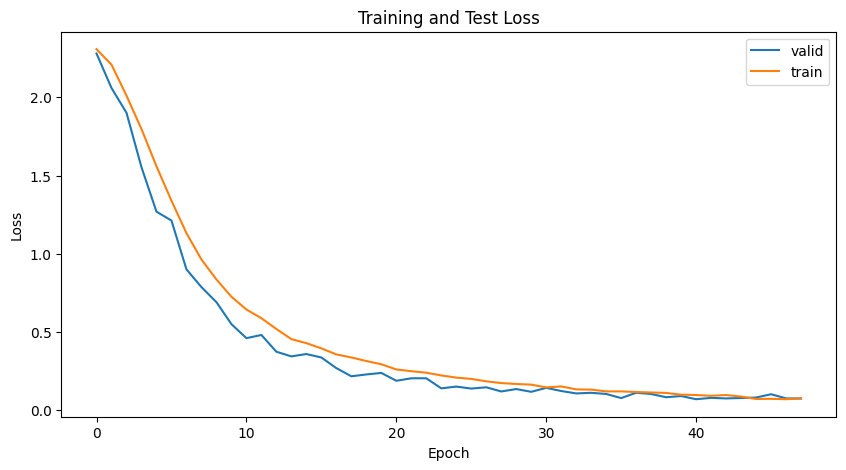

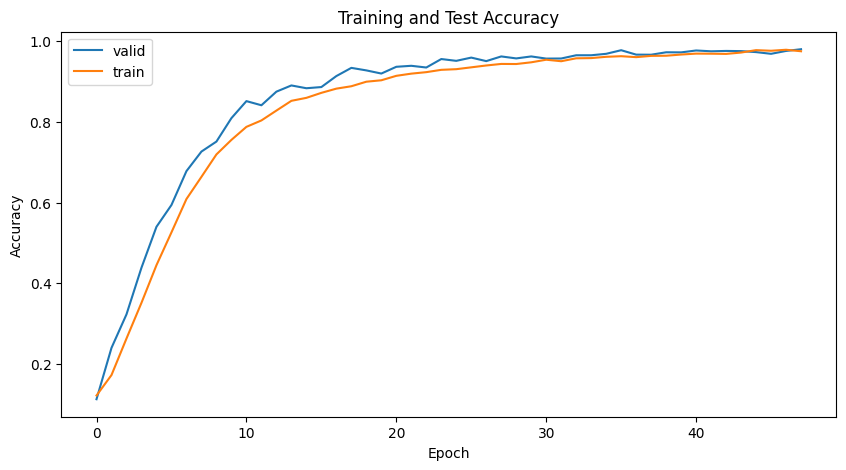

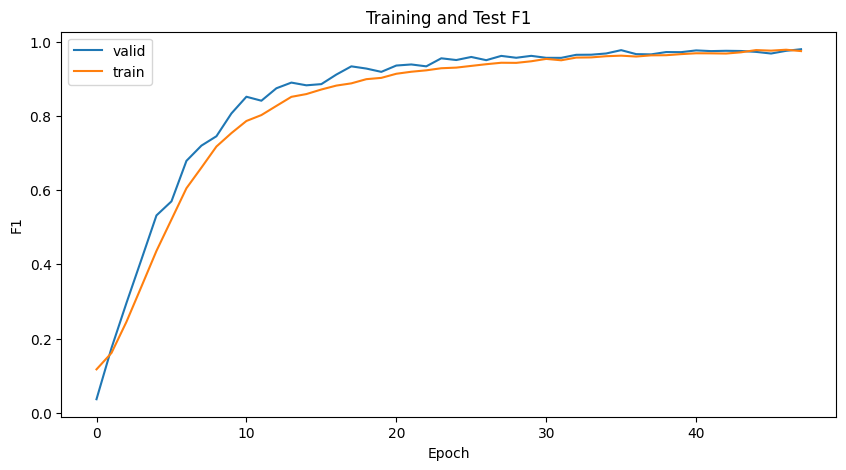

In [14]:
run_training(train_loader, val_loader, model, model_name, criterion, optimizer, config)

## Inference

In [15]:
class InferenceDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        super().__init__()
        self.images_dir = images_dir
        self.transform = transform

        self.images = os.listdir(images_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # to submit to kaggle competition I need to return image name
        return img_name, image

In [16]:
def inference(test_loader, model, model_name, config):
    if model_name == 'resnet50' or model_name == 'resnet101':
        model.fc = nn.Linear(2048, 10)
    elif model_name == 'cvt_3' or model_name == 'cvt_7' or model_name == 'cvt_14':
        pass
    elif model_name == 'vit_lite32' or model_name == 'vit_lite16':
        pass
    else:
        raise NotImplementedError('unknown architecture')
    
    model = model.to(config['DEVICE'])
    model.load_state_dict(torch.load(os.path.join(config['MODELS_DIR'], f'{model_name}_best_model.pth')))
    model.eval()
    
    df = pd.DataFrame()
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc='Inference'):
            img_name, imgs = data
            imgs = imgs.to(config['DEVICE'])

            logits = model(imgs)
            probas = F.softmax(logits, dim=1)
            
            block = np.concatenate((np.array(img_name).reshape(-1, 1), probas.detach().cpu().numpy()), axis=1)
            block = pd.DataFrame(block, columns=['img', 'c0', 'c1', 'c2',
                                                 'c3', 'c4', 'c5',
                                                 'c6', 'c7', 'c8',
                                                 'c9'])
            df = pd.concat((df, block), axis=0, ignore_index=True)
    return df

In [17]:
test_transformations = val_transforms
test_dataset = InferenceDataset(config['TEST_DIR'], transform=test_transformations)
test_loader = DataLoader(test_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

# this csv file will be submitted to kaggle
df = inference(test_loader, model, model_name, config)

Inference: 100%|██████████| 1246/1246 [05:16<00:00,  3.94it/s]


In [18]:
df.to_csv(f'submission {model_name}.csv', index=False)